

Is this sample representative?

In [703]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

from src.paths import DATA

%matplotlib inline
plt.style.use('bmh')

In [538]:
df = pd.read_csv(DATA / 'ml_project1_data_pre_processed.csv')
df_complement = pd.get_dummies(df[['Education','Marital_Status']])
df = pd.concat([df,df_complement], axis=1)
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Education_Master,Education_PhD,Marital_Status_Absurd,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Marital_Status_YOLO
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,0,0,0,0,1,0,0,0
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,0,0,0,0,1,0,0,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,0,0,0,0,0,1,0,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,0,0,0,0,0,1,0,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,1,0,0,0,1,0,0,0,0


In [847]:
data = df[[ 'Recency', 'MntTotal', 'Income', 'Response', 'AcceptedTotalFirstFiveCmps', 'NumStorePurchases', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together', 'Education_Graduation', 'Education_Master',
       'Education_PhD']]

data = data.query("Income < 118000")
#data = data.query("Age < 121")
data = data[data.Income.notnull()]

X_train, X_test, y_train, y_test = train_test_split(data.drop('Response',axis=1), data['Response'],test_size=0.3)

In [848]:
X_train.shape, X_test.shape

((1542, 13), (661, 13))

In [849]:
y_train.shape,y_test.shape

((1542,), (661,))

In [850]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [851]:
for feature, importancies in zip(data.drop('Response',axis=1), clf.feature_importances_):
    print(f"{feature}:{importancies:.3f}")

Recency:0.215
MntTotal:0.165
Income:0.211
AcceptedTotalFirstFiveCmps:0.198
NumStorePurchases:0.100
Marital_Status_Alone:0.000
Marital_Status_Divorced:0.012
Marital_Status_Married:0.014
Marital_Status_Single:0.019
Marital_Status_Together:0.032
Education_Graduation:0.011
Education_Master:0.011
Education_PhD:0.011


In [852]:
resultado = clf.predict(X_test)
print(metrics.classification_report(y_test,resultado))

              precision    recall  f1-score   support

       False       0.91      0.90      0.90       568
        True       0.41      0.43      0.42        93

    accuracy                           0.83       661
   macro avg       0.66      0.66      0.66       661
weighted avg       0.84      0.83      0.84       661



In [853]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Response',
       'Z_Revenue_correct', 'Age', 'MntTotal', 'NumTotalPurchases',
       'AcceptedTotalFirstFiveCmps', 'AcceptedTotalFirstFiveCmpsMorePilot',
       'TotalYearAfterRegistration', 'TotalChildren', 'Education_2n Cycle',
       'Education_Basic', 'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow', 'Ma

In [854]:
from sklearn.linear_model import LogisticRegression

In [947]:
data = df[[ 'Recency', 'MntTotal', 'Income', 'Response','Education_2n Cycle',
       'Education_Graduation', 'Education_Master',
       'Education_PhD', 'Marital_Status_Absurd', 'Marital_Status_Alone',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Together',
       'Marital_Status_Widow','AcceptedTotalFirstFiveCmps']]

data = data.query("Income < 118000")
#data = data.query("Age < 121")
data = data[data.Income.notnull()]

X_train, X_test, y_train, y_test = train_test_split(data.drop('Response',axis=1), data['Response'],test_size=0.3)

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [948]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [949]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       False       0.90      0.97      0.93       561
        True       0.67      0.38      0.48       100

    accuracy                           0.88       661
   macro avg       0.78      0.67      0.71       661
weighted avg       0.86      0.88      0.86       661



In [950]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[542,  19],
       [ 62,  38]], dtype=int64)

In [951]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.8774583963691377
Precision: 0.6666666666666666
Recall: 0.38


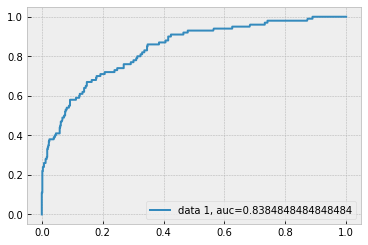

In [952]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [946]:
pd.DataFrame(logreg.predict_proba(X_test))

,0,1
0,0.949932,0.050068
1,0.991260,0.008740
2,0.833493,0.166507
3,0.790546,0.209454
4,0.163214,0.836786
5,0.357499,0.642501
6,0.863044,0.136956
7,0.941381,0.058619
8,0.818662,0.181338
9,0.672756,0.327244


In [895]:
logreg.predict(X_test)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [901]:
logreg.score()

TypeError: score() missing 2 required positional arguments: 'X' and 'y'

In [891]:
logreg.coef_

array([[-2.97400731e-02,  1.32377508e-03, -3.07650388e-05,
        -5.45152908e-02, -1.51637083e-01, -6.03227151e-02,
         1.80974397e-01,  1.18189326e-02,  9.05778024e-03,
         1.23327253e-01, -3.59066738e-01,  2.86160785e-01,
        -2.71196110e-01,  4.43124605e-02,  1.34957237e+00]])